In [143]:
from collections import Counter, defaultdict
import random, math
import numpy as np
import pandas as pd
from scipy import stats
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

### 1D DATA

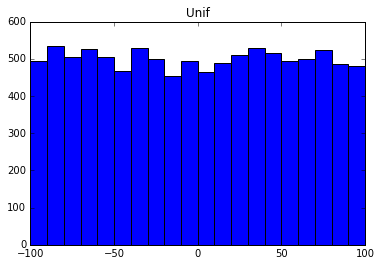

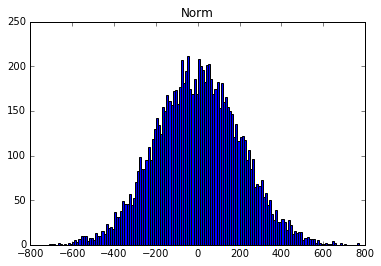

In [21]:
# BUCKETIZE -> HISTOGRAM SUMMARY
data1dUnif = [200*random.random()-100 for _ in range(10000)]
data1dNorm = [200*random.normalvariate(0,1) for _ in range(10000)]
def bucketize(point, bucketSize):
    # floor the point to the next lower multiple of bucketSize.
    return bucketSize * math.floor(point / bucketSize)
def make_histogram(points, bucketSize):
    # buckets the points and counts how many in each bucket.
    return Counter(bucketize(point, bucketSize) for point in points)
def plot_histogram(points, bucketSize, title=""):
    histogram = make_histogram(points, bucketSize)
    plt.bar(histogram.keys(), histogram.values(), width=bucketSize)
    plt.title(title)
    plt.show()
plot_histogram(data1dUnif, 10, title='Unif')
plot_histogram(data1dNorm, 10, title='Norm')

### 2D DATA

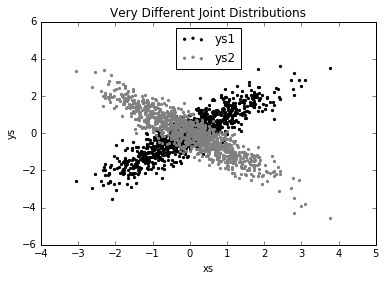

correlation: xs, ys1: cor=0.887183521345, p-value=0.0
correlation: xs, ys2: cor=-0.893791808113, p-value=0.0


In [60]:
def random_normal():
    return random.normalvariate(0,1)
xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title('Very Different Joint Distributions')
plt.show()
print 'correlation: xs, ys1: cor=%s, p-value=%s' % stats.pearsonr(xs, ys1)
print 'correlation: xs, ys2: cor=%s, p-value=%s' % stats.pearsonr(xs, ys2)

### N-D DATA

In [65]:
# CORRELATION MATRIX
np.random.seed(0)
data = pd.DataFrame(np.floor(10*np.random.random((3,4))))
''' data
     0    1    2    3
0  5.0  7.0  6.0  5.0
1  4.0  6.0  4.0  8.0
2  9.0  3.0  7.0  5.0
'''
def get_row(data, i): return data.loc[i]
def get_col(data, i): return data[i]
def correlation_matrix(data):
    _, numCols = data.shape
    def matrix_entry(i, j):
        return stats.pearsonr(get_col(data,i), get_col(data,j))[0]
    def make_matrix(data, numCols):
        mCor = np.zeros((numCols,numCols))
        for i in range(numCols):
            for j in range(numCols):
                mCor[i,j] = matrix_entry(i,j)
        return mCor
    return make_matrix(data, numCols)
print correlation_matrix(data)

[[ 1.         -0.9078413   0.8660254  -0.65465367]
 [-0.9078413   1.         -0.57655666  0.2773501 ]
 [ 0.8660254  -0.57655666  1.         -0.94491118]
 [-0.65465367  0.2773501  -0.94491118  1.        ]]


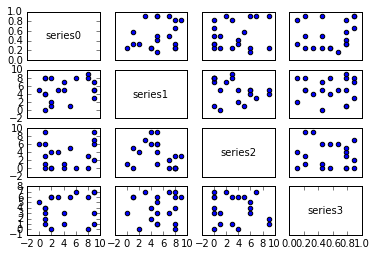

In [79]:
# PAIRWISE SCATTER PLOT (ASSUMING P IS NOT GIGANTIC)
np.random.seed(1)
data = pd.DataFrame(np.floor(10*np.random.random((20,4))))
numCols = data.shape[1]
fig, ax = plt.subplots(numCols, numCols)
    # fig: figure/image object (e.g. used to save image).
    # ax: graph object, used to configure graph.
for i in range(numCols):
    for j in range(numCols):
        if i != j: ax[i][j].scatter(get_col(data,j), get_col(data,i))
        else: ax[i][j].annotate('series' + str(i), (.5,.5), xycoords='axes fraction', ha='center', va='center')
                # on diagonal, annotate with series name.
        if i < numCols - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
            # get rid of separate x, y axes of individual subplots.
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())
    # fixing axes of top-left and bottom-right 
    # (these are annotations, therefore wrong labels, need to borrow from others)
plt.show()

### NORMALIZATION

In [248]:
# DATA: BY DIFFERENT UNITS
data = pd.DataFrame(np.array([63,160,150,67,170,160,70,178,171]).reshape((3,3)), 
                    columns=['height_by_inch','height_by_centimeter','weight'])
data

,height_by_inch,height_by_centimeter,weight
0,63,160,150
1,67,170,160
2,70,178,171


In [249]:
# ACCESSING DATAFRAME W/ COL NAMES
data['height_by_centimeter'][0]

160

In [250]:
# NORMALIZATION FUNCTIONS
def get_row(data, i): return data.loc[i]
def get_col(data, i): return data[i]
def make_matrix(numRows, numCols, rescaled):
    matrixRescaled = pd.DataFrame(np.zeros((numRows, numCols)),columns=data.columns)
    for j in range(numCols):
        for i in range(numRows):
            matrixRescaled[matrixRescaled.columns[j]][i] = rescaled(i,j)
    return matrixRescaled
def scale(data):
    # returns mean & std of cols as two lists.
    numRows, numCols = data.shape
    means = [np.mean(get_col(data,data.columns[j])) for j in range(numCols)]
    stds = [np.std(get_col(data,data.columns[j])) for j in range(numCols)]
    return means, stds
    # ([66.666666666666671, 169.33333333333334, 160.33333333333334],
    #  [2.8674417556808756, 7.3635740114581738, 8.5764535535124047])
def rescale(data):
    # rescale input data so that each column has mean 0 and std 1.
    means, stds = scale(data)
    def rescaled(i, j):
        if stds[j] > 0: # only handles cols w/ deviation!
            return(data[data.columns[j]][i] - means[j]) / stds[j]
        else: 
            return data[data.columns[j]][i]
    numRows, numCols = data.shape
    return make_matrix(numRows, numCols, rescaled)
rescale(data)

,height_by_inch,height_by_centimeter,weight
0,-1.278724,-1.267500,-1.204849
1,0.116248,0.090536,-0.038866
2,1.162476,1.176965,1.243715


### DIMENSION REDUCTION (PCA)

In [317]:
# PREREQUISITE
#   RUN GRADIENT_DESC.PY

In [399]:
# DIRECTIONAL VARIANCE EVALUATION
def de_mean_matrix(data):
    # takes a matrix, return a transformed one s.t. column means = 0.
    numRows, numCols = data.shape
    columnMeans, _ = scale(data)
    return make_matrix(numRows, numCols, lambda i, j: data[data.columns[j]][i] - columnMeans[j])
def direction(w):
    # every nonzero vector determines a direction if 
    #   we rescale it to have magnitude 1.
    mag = magnitude(w)
    return [w_i / mag for w_i in w]
def directional_variance_i(x_i, w):
    # given a nonzero vector w, compute the var of our dataset
    #   in the direction determined by w.
    return dot(x_i, direction(w)) ** 2
def directional_variance(X, w):
    # the total variance of dataset in the direction determined by w.
    return sum(directional_variance_i(X.loc[i], w) for i in range(X.shape[0])) #### NOW ITERATING ON ROW

In [400]:
# GRADIENT DESCENT
def directional_variance_gradient_i(x_i, w):
    # the contribution of row x_i to the gradient of the direction-w variance.
    projLen = dot(x_i, direction(w))
    return [2*projLen*x_ij for x_ij in x_i] # 2*x, again, is d(x^2).
def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(X.loc[i], w) for i in range(X.shape[0])) #### NOW ITERATING ON ROW

In [419]:
# FIRST PC
#   version 1: batch
def first_principal_component(X):
    guess = [100 for _ in X] ## NOW ITERATING ON COL
    unscaledMaximizer = maximize_batch(
        partial(directional_variance, X), 
            # directional_variance takes 2 args,
            #   here we run partial to let it take X first,
            #   and then get w from 'guess'.
        partial(directional_variance_gradient, X),
        guess
        # guess will be adjusted (it's basically theta_0),
        #   in the process of maximization.
    )
    return direction(unscaledMaximizer)
#   version 2: stochastic
def first_principal_component_sgd(X):
    guess = [100 for _ in X]
    unscaledMaximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w), 
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X,
        [None for _ in X], # the fake 'y'.
        guess
    )
    return direction(unscaledMaximizer)

In [420]:
# PROJECTION
#   say x is the original vector, w is the direction of 1st PC,
#   then x - w is the (perpendicular) distance from x to w.
#   this is used to find the 2, 3, kth ... PCs.
def project(v, w):
    # return the projection of v onto the direction w.
    projLen = dot(v, w)
    return scalar_multiply(projLen, w)
def remove_projection_from_vector(v, w):
    return vector_subtract(v, project(v, w))
def remove_projection(X, w):
    # remove_projection on a matrix X, it is transformed to 
    #   the perpendicular space of its first PC.
    return [remove_projection_from_vector(X.loc[i], w) for i in range(X.shape[0])] #### NOW ITERATING ON ROW

In [421]:
# HARVEST PCs
def principal_component_analysis(X, numComps):
    components = []
    for _ in range(numComps):
        component = first_principal_component(X)
        components.append(component)
        X = pd.DataFrame(remove_projection(X, component))
    return components
# TO-LOWER-D TRANSFORMATION
def transform_vector(v, components):
    return [dot(v, w) for w in components]
def transform(X, components):
    return [transform_vector(X.loc[i], components) for i in range(X.shape[0])] #### NOW ITERATING ON ROW

In [422]:
components = principal_component_analysis(d1,3)
print components

[[0.50458246874611934, 0.57451940761082199, 0.64445634647552474], [0.76345432529383495, 0.060202207388508726, -0.64304991051681704], [0.5773502691896257, 0.5773502691896257, 0.5773502691896257]]


In [398]:
# FIND OPTIMAL STEPSIZE
stepSizes = [100,10,1,.1,.01,.001,.0001,.00001]
def safe(f):
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f
    # safe function: a function that takes a function f and returns
    #    a new function f' which is the same as f except that it outputs
    #    infinity whenever f produces an error.
    # NB: infinity can never minimize anything!
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=.000001):
    # target_fn: cost function (e.g. sum of squares function).
    # gradient_fn: gradient/slope evaluator (e.g. deriv(x)=2*x in sum of squares).
    # theta_0: initial theta values.
    # tolerance: delta threshold, if smaller than it, stop.
    stepSizes = [100,10,1,.1,.01,.001,.0001,.00001]
    theta = theta_0 # parameter initialization.
    target_fn = safe(target_fn) # make sure target_fn doesn't invoke error.
    value = target_fn(theta) # f(x), i.e. the value we are minimizing.
    while True:
        gradient = gradient_fn(theta)
        nextThetas = [ step(theta, gradient, -stepSize) for stepSize in stepSizes ]
            # compute: according to each step size, how much does x change.
        nextTheta = min(nextThetas, key=target_fn) # next x is the one that minimizes f(x).
        nextValue = target_fn(nextTheta) # next f(x).
        if abs(value - nextValue) < tolerance:
            return theta
        else: 
            theta, value = nextTheta, nextValue
# BASIC VECTOR OPERATIONS
def vector_add(v, w):
    return [v_i + w_i for v_i, w_i in zip(v,w)]
def vector_subtract(v,w):
    return [v_i - w_i for v_i, w_i in zip(v,w)]
def vector_sum1(vectors):
    result = vectors[0]
    for vector in vectors[1:]:
        result = vector_add(result, vector)
    return result
def vector_sum2(vectors):
    return reduce(vector_add, vectors)
def vector_sum3(vectors):
    return partial(reduce, vector_add)
def scalar_multiply(c, v):
    return [c*v_i for v_i in v]
def vector_mean(vectors):
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum2(vectors))
def dot(v, w):
    return sum(v_i*w_i for v_i, w_i in zip(v, w))
def sum_of_squares(v):
    return dot(v,v)
def magnitude(v): # length of vector
    return math.sqrt(sum_of_squares(v))
def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))
def distance1(v, w):
    return math.sqrt(squared_distance(v, w))
def distance2(v, w):
    return magnitude(vector_subtract(v, w))
# FIND THE MINIMUM
#    x+ if grad=neg; x- if grad=pos.
#    DEMO: smallest 3D vector.
def step(v, direction, stepSize): # direction = gradient.
    return [v_i + stepSize * direction_i for v_i, direction_i in zip(v, direction)]
    # step function returns the x value after movement based on f(x).
def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]
v = [random.randint(-10,10) for i in range(3)] # generate random 3D vector (val=[-10,10]).
tolerance = .0000001 # if the value change < tolerance, stop.
def distance(v, w):
    return math.sqrt(sum(v1*v2 for v1,v2 in zip([v_i - w_i for v_i, w_i in zip(v,w)],[v_i - w_i for v_i, w_i in zip(v,w)]) ) )
    # substract -> square -> sum -> square root.
while True:
    gradient = sum_of_squares_gradient(v)
    nextV = step(v, gradient, -.01)
    if distance(nextV, v) < tolerance:
        break
    v = nextV
def in_random_order(data):
    indices = [i for i, _ in enumerate(data)]
    random.shuffle(indices)
    for i in indices:
        yield data[i]
# STOCHASTIC GRADIENT DESCENT
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=.01):
    data = zip(x,y)
    theta = theta_0
    alpha = alpha_0
    minTheta, minValue = None, float('inf')
    iterationWithNoImprovement = 0
    while iterationWithNoImprovement < 100:
        value = sum(target_fn(x_i,y_i,theta) for x_i,y_i in data)
        if value < minValue:
            minTheta, minValue = theta, value
            iterationWithNoImprovement = 0
            alpha = alpha_0
        else:
            iterationWithNoImprovement += 1
            alpha *= .9 # smaller step.
        for x_i,y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i,y_i,theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
    return minTheta
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradient_fn), x, y, theta_0, alpha_0)

In [431]:
# OPTIMAL SOLUTION
from matplotlib.mlab import PCA
results = PCA(d1)
results.Wt

array([[ 0.57735027,  0.57735027,  0.57735027],
       [-0.81649658,  0.40824829,  0.40824829],
       [ 0.        , -0.70710678,  0.70710678]])